# PID Control

Imagine that you prepared some milk to feed your baby, but the milk's temperature is only 25°C and it should be 37°C. The ambient temperature in your room is 20°C and this will cool down your milk. Luckily, you have a device which can heat up your milk . The device uses electricity to produce heat and you can manipulate the power $u$. You are also able to monitor the milk's temperature $T$. What you are facing is a *control problem*.

Before we explore a solution, let us write down some code to simulate the scenario. We will model the temperature dynamics via Newton's law of cooling

$$
    \frac{dT}{dt}=\alpha (T_a - T(t)) + \beta u(t)
$$ (milk_ode)

Here, $d/dt$ is the time derivative, $T_a$ is the ambient temperature and $u$ the power of the heating device. $\alpha$ and $\beta$ are constants. We are not going to try to estimate realistic values for $\alpha$ and $\beta$ for our problem. This is just a toy example. Using the equation above, let us write some simulation code. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from IPython import display
display.set_matplotlib_formats('svg')

In [3]:
#define constants
alpha, beta = 1, 40
T_ambient, T_desired, T_start = 20, 37, 25

# system update by discretization of the differential eq.
def next_temp(u, T, dt):
    return T+alpha*(T_ambient-T)*dt + beta * u *dt

def simulate_temp(controller, num_steps=20):
    dt = 0.1 # Every time interval dt we set a new control value
    T = T_start
    T_list = [T]
    for k in range(num_steps):
        # ask controller for u value
        u = controller.get_control(T,dt)
        # device only allows to set u between 0 and 1:
        u = np.clip(u, 0, 1)
        # simulate what the temperature will be after time interval dt
        T = next_temp(u, T, dt)
        T_list.append(T)
    time = dt*np.arange(num_steps+1)
    plt.plot(time, np.repeat(T_desired, num_steps+1), ls="--")
    plt.plot(time, T_list)
    plt.xlabel("time"); plt.ylabel("Temperature");

The `simulate_temp` function needs a `controller` object as an input. This `controller` has a function `get_control()`, which looks at the current temperature `T` and the time `dt` that has elapsed since the last control command was issued. It tells us to which power $u$ we should set our heating device.

First let us create a very silly controller: It will always set $u$ to zero. Hence, we are not heating the milk and it will cool down to the ambient temperature:

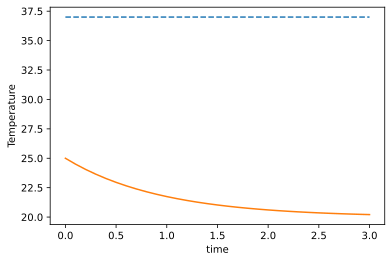

In [4]:
class SillyController:
    def get_control(self,T,dt):
        return 0
silly_controller = SillyController()
simulate_temp(silly_controller, num_steps=30)

Indeed, if we do nothing, the milk cools down. But now let us try to create a proper controller. 

## P Controller
The idea of the P controller or proportional controller is simple: Imagine that you are turning a knob on the heating device that sets the value of $u$. You look at the difference between the desired temperature and the current temperature, the so-called error. If the error is large and positive (desired temperature > current temperature) you choose $u$ to be large and positive. This will heat up the milk and the error will go down. The more the error goes down, the more you would turn the $u$-knob towards zero. If the error is negative, i.e., the current milk temperature is too high (dangerous for the baby!), you would like to cool the milk down by setting $u$ to a negative value. Sadly, this is something you cannot do with your electrical heater [^foot_note_negative_u]).

[^foot_note_negative_u]: You can imagine other control problems, where the control input $u$ does not need to be positive. For example you might want to control the torque on the wheels of a car in order to park at a specific position. If you have driven too far, you can set a negative torque and drive backwards.

In summary, you choose $u$ to be proportional to the error. We can implement the P controller as follows

In [5]:
class PController:
    def __init__(self, Kp, set_point):
        self.Kp = Kp
        self.set_point = set_point
    
    def get_control(self, measurement, dt):
        error = self.set_point - measurement
        return self.Kp * error

The `PController` computes the difference between a `set_point` (desired temperature) and a `measurement` (current temperature). This difference is called the `error`. The control value is just a positive constant `Kp` multiplied with the `error`. The constant `Kp` is known as the *proportional gain*, and finding a good value for `Kp` is called *tuning the controller*. Note that the `PController` knows nothing about heat or Newton's law of cooling. It does not rely on a model of how the control value $u$ influences the world.  

The mathematical formula for the P controller is 

$$u(t) = K_p e(t)$$

Here, $e$ denotes the error. Now, let us apply the `PController` and see what happens to the milk:

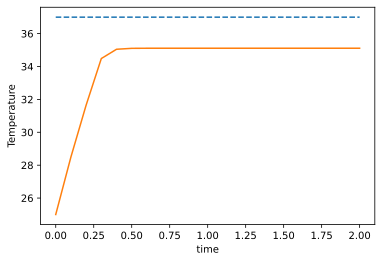

In [6]:
p_controller = PController(Kp=0.2, set_point=T_desired)
simulate_temp(p_controller)

As you can see, the milk's temperature goes up, but not quite to the value we wanted. There is still a gap between the actual temperature and the desired temperature. This is known as *steady state error* and is a typcial problem with a `PController`. 

In a real system it can be hard to understand why there is a *steady state error*, because we might not even have a model of the system. For our simulated milk system however, we can understand it: Assume that the actual temperature is equal to the desired temperature. Then the error `T_desired-T` is zero and hence `u=K_d * (T_desired-T)` is zero. This means no heat is added and the milk cools down below `T==T_desired`. A steady state is reached when the heat generated by the error is equal to the heat that is lost to the room. 

Now we could increase the `set_point` to "desired temperature plus a bit more". This would increase the steady state temperature and make it come closer to our desired temperature. But there exists a much better solution! The proportional integral or PI controller! 

## PI Controller

The formula for the PI controller is

$$u(t) = K_p e(t) + K_I \int_0^t e(t) dt$$

The control variable now depends on the time integral of the error. Imagine the situation from before: We have a P controller, which comes close to the desired temperature but there is still a gap. If we now switch to a PI controller, the integral term $K_I \int_0^t e(t) dt$ grows over time and it will close the gap. The integral term is looking into the past and saying "Hey, we have been below the `set_point` for quite some while now! We should increase the heat!". Let us implement the PI controller and see how it solves the steady-state error problem:

In [7]:
class PIController:
    def __init__(self, Kp, Ki, set_point):
        self.Kp = Kp
        self.Ki = Ki
        self.set_point = set_point
        self.int_term = 0
    
    def get_control(self, measurement, dt):
        error = self.set_point - measurement
        self.int_term += error*self.Ki*dt
        return self.Kp * error + self.int_term

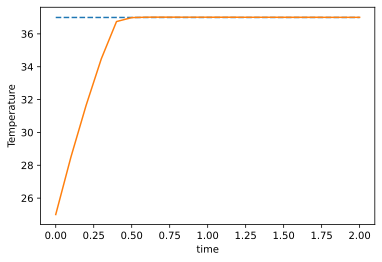

In [8]:
pi_controller = PIController(Kp=0.2, Ki = 0.15, set_point=T_desired)
simulate_temp(pi_controller)

We are pretty happy with our milk now. For this problem, the PI controller is a nice solution. There are other problems however, where it might not be enough to look into the past with the integral term. We also need to look into the future. This is what the derivative term in the PID controller does. 

## PID Controller
The formula of the PID controller is

$$u(t) = K_p e(t) + K_I \int_0^t e(t) dt + K_d \frac{de}{dt}$$

and the implementation looks like this

In [9]:
class PIDController:
    def __init__(self, Kp, Ki, Kd, set_point):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.set_point = set_point
        self.int_term = 0
        self.derivative_term = 0
        self.last_error = None
    
    def get_control(self, measurement, dt):
        error = self.set_point - measurement
        self.int_term += error*self.Ki*dt
        if self.last_error is not None:
            self.derivative_term = (error-self.last_error)/dt*self.Kd
        self.last_error = error
        return self.Kp * error + self.int_term + self.derivative_term

For our milk problem, we do not gain much using the PID controller. You can play with the parameters $K_p, K_i, K_d$ on the sliders below to see that the derivative term is actually not helping much here.

```{note}
Manipulating the sliders currently has not effect on this page. Click the rocket-shaped button in the top-right corner of this page and select "Colab" to get a jupyter notebook version of this website. Run all cells to generate the sliders, then enjoy the interactivity.
```

In [10]:
# create sliders
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets
def run_pid_temp(Kp,Ki,Kd):
    pid_controller = PIDController(Kp, Ki, Kd, set_point=T_desired)
    simulate_temp(pid_controller)

Kp_slider = FloatSlider(min=0.0, max=0.8, step=0.05, readout_format='.4f')
Ki_slider = FloatSlider(min=0.0, max=0.2, step=0.01, readout_format='.4f')
Kd_slider = FloatSlider(min=-3e-3, max=3e-3, step=2e-4, readout_format='.4f')
interact(run_pid_temp, Kp=Kp_slider, Ki=Ki_slider, Kd=Kd_slider);

interactive(children=(FloatSlider(value=0.0, description='Kp', max=0.8, readout_format='.4f', step=0.05), Floa…

There are problems however, where the derivative term of the PID controller is very important. Imagine a drone flying at height $p$ above the ground. We want it to stay at a desired height of $p=p_d=50$ meters. We can control the drone's upwards acceleration $a$ (hence $u=a$) and have to take into account that there is a constant downwards acceleration $g$ due to gravity.
Let us have a look at a toy simulation of the drone. The state of the simulation consists of the drones position and velocity. The controller only measures the position and issues an acceleration command. Note that you do not need to understand the details of the simulation code

In [11]:
g = -9.81
p_desired = 50

# system update
def next_state(a, state, dt):
    aeff = a + g
    position, velocity = state 
    # integration by velocity verlet algorithm
    position += velocity*dt + 0.5*aeff*dt**2
    velocity += aeff*dt
    return (position,velocity)

def simulate_drone(controller, num_steps = 1000):
    dt = 0.02
    state = (0,0)
    state_list=[state]
    for i in range(num_steps):
        a = controller.get_control(state[0], dt)
        # upwards acceleration is positive (>0)
        # and limited by power supply (<100)
        a = np.clip(a, 0, 100)
        state = next_state(a, state, dt)
        state_list.append(state)
    s = np.array(state_list)
    time = dt*np.arange(num_steps+1)
    plt.plot(time, [p_desired]*(num_steps+1), ls="--")
    plt.plot(time, s[:,0])
    plt.gca().set_ylim(-100,100)
    plt.xlabel("time"); plt.ylabel("drone height");

Using the interactive sliders below, try to find values of $K_p, K_i, K_d$ that make the drone hover at 50 meters. You will need to use all three terms of the PID controller here.

```{note}
Manipulating the sliders currently has not effect on this page. Click the rocket-shaped button in the top-right corner of this page and select "Colab" to get a jupyter notebook version of this website. Run all cells to generate the sliders, then enjoy the interactivity.
```

In [12]:
# create sliders
def run_pid_drone(Kp,Ki,Kd):
    pid_controller = PIDController(Kp, Ki, Kd, set_point=p_desired)
    simulate_drone(pid_controller)

Kp_slider = FloatSlider(min=0, max=10, step=0.1, readout_format='.4f')
Ki_slider = FloatSlider(min=0.0, max=0.5, step=0.05, readout_format='.4f')
Kd_slider = FloatSlider(min=-3, max=3, step=0.1, readout_format='.4f')
interact(run_pid_drone, Kp=Kp_slider, Ki=Ki_slider, Kd=Kd_slider);

interactive(children=(FloatSlider(value=0.0, description='Kp', max=10.0, readout_format='.4f'), FloatSlider(va…

You should find parameters where the control works smoothly. When you do not use the derivative term you will find that the drone oscillates around the target position. But why? If the drone is too low, the controller will make it increase its upwards position such that it can reach the target position. But once it reaches that position, it still has some upwards momentum and will hence continue to move upwards. This overshoot due to inertia can be tackled by the derivative term, which is

$$u(t) = K_d \frac{de}{dt} = K_d \frac{d}{dt}\bigg(p_d-p(t)\bigg) = K_d \left(0-\frac{dp}{dt}\right) = -K_d \frac{dp}{dt}$$

Assuming $K_d>0$ the formula above reveals: If the velocity $dp/dt$ is positive (upwards), the control $u$, which is the acceleration $a$, will be negative (downwards). Hence the derivative term acts against the problem of overshoot and oscillation.

Within this section we always tuned the PID parameters $K_p, K_i, K_d$ manually. For the application within this book this is good enough. But if you want to learn about more methodical and even automatic tuning methods, check out the [Wikipedia Article on PID](https://en.wikipedia.org/wiki/PID_controller).

Before we finish our introduction to PID, we shortly mention its limitations. One of its advantages is also a disadvantage: its independence on a system model. PID solely reacts on the error. If you have no model, this is great, since you might be able to control something that you do not understand in detail. However, if you do have a model, it will not improve the capability of your PID controller. If you are not happy with the PID controller's performance, a model-based controller could be a better choice in this case. 
There is also one problem with PID called *integral windup* . If the set point is far from the current value, the integral term can accumulate and get really large while the system moves towards the set point. This will lead to an overshoot. Luckily, this problem can be solved by slightly adjusting the implementation of the `PIDController`. For example, you could clip the integral term, which means not allowing it to grow beyond some user-specified threshold.

```{tip}
This section gave you a gentle introduction to PID control using examples. For more details on PID, see the [Wikipedia Article](https://en.wikipedia.org/wiki/PID_controller) or this [youtube playlist by Brian Douglas](https://www.youtube.com/playlist?list=PLn8PRpmsu08pQBgjxYFXSsODEF3Jqmm-y). If you are interested in control theory in general, I can recommend [Steve Brunton's Control bootcamp on youtube](https://www.youtube.com/playlist?list=PLMrJAkhIeNNR20Mz-VpzgfQs5zrYi085m)
```

Enough about baby milk and drones. You want to control a vehicle in the Carla simulator! We can use PID for the longitudinal control of the vehicle, i.e., to set the gas pedal properly. PID is not so well suited for lateral control, i.e., controlling the steering wheel. For that you will implement a method called pure pursuit. Once you understand what pure pursuit is, you will apply PID and pure pursuit inside Carla.